In [1]:
#pip install --upgrade scikit-learn

<div style="background-color: #e8f5e9; padding: 20px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 1000px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 36px; margin-bottom: 10px; text-align: center;">
        MODEL BUILDING
    </h2>
</div>


<div style="text-align: center;">
    <img src="../images/bg.jpeg" width="400" height="400" />
</div>

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, f1_score,
precision_score, recall_score)
from typing import Dict, Any

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

import pickle
import warnings
warnings.filterwarnings('ignore')

C:\Users\Darrin DeYoung\anaconda3\envs\myenv\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
df = pd.read_csv('../Data/Heart_Disease_Prediction.csv')
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,80,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,55,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,65,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,45,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [4]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (270, 14)


In [5]:
df['Heart Disease'] = df['Heart Disease'].replace({'Presence': 1, 'Absence':0})

### 1. Outliers Detection

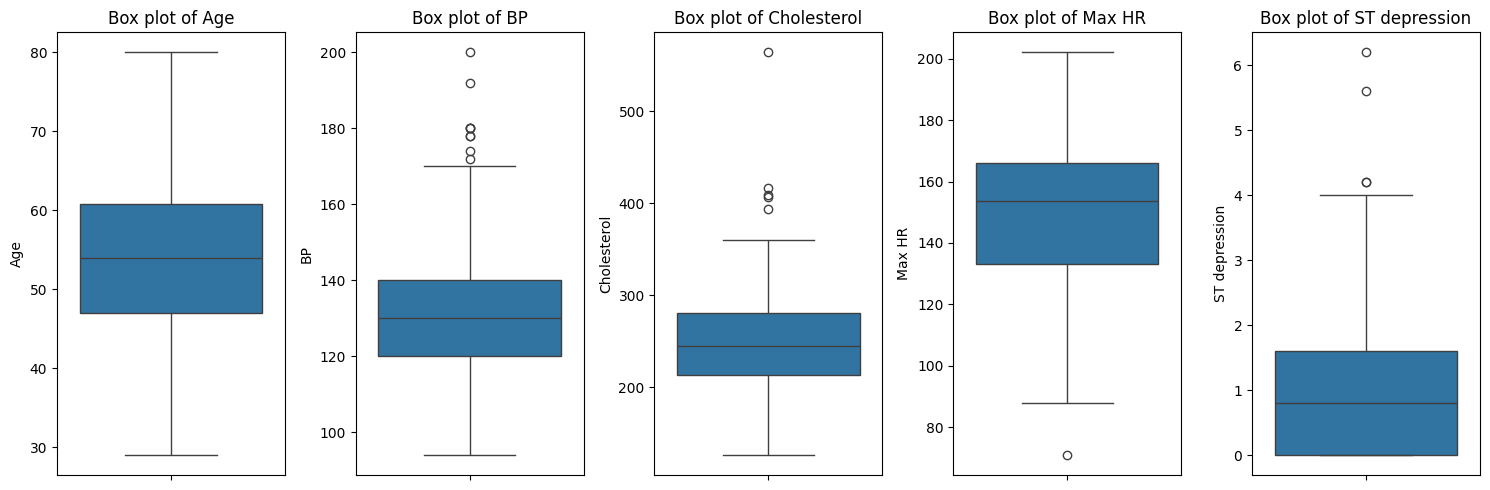

In [6]:
continuous_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(1, len(continuous_features), i)
    sns.boxplot(y=df[feature])
    plt.title(f'Box plot of {feature}')

plt.tight_layout()
plt.show()

In [7]:
# This function uses the IQR method to detect outliers.
def count_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)  # 25th percentile
    Q3 = df[column_name].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                        # Interquartile range
    
    # outlier range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Finds outliers
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    # Return the number of outliers
    return len(outliers)

In [8]:
continuous_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
outlier_counts = {}

outlier_counts = {feature: count_outliers_iqr(df, feature) for feature in continuous_features}
for feature, count in outlier_counts.items():
    print(f'Number of outliers in {feature}: {count}')

Number of outliers in Age: 0
Number of outliers in BP: 9
Number of outliers in Cholesterol: 5
Number of outliers in Max HR: 1
Number of outliers in ST depression: 4


* Outliers in our data are relatively few, so using a Robust Scaler is a suitable approach.
* Robust Scaler is effective in scaling features while minimizing the influence of outliers, as it scales based on the interquartile range (IQR) rather than the mean and standard deviation, which makes it more robust to outliers.

In [9]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,80,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,55,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,65,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,45,0,2,120,269,0,2,121,1,0.2,1,1,3,0


### Workflow:
#### Step 1: Splitting the data into training and test sets.
#### Step 2: Set up a Pipeline for scaling and modeling: 
    To ensure that scaling and modeling steps are applied sequentially within cross-validation. This way, scaling is done within each CV fold, avoiding leakage of information from the test data in each fold.
#### Step 3: Hyperparameter Tuning with Cross-Validation : 
    Cross-validation will handle splitting the training data into folds, and scaling will be applied within each fold.
#### Step 4: Evaluate the Best Model on the Test Set

* Pipeline: Using a pipeline ensures that scaling and transformations are applied within each fold of cross-validation, preventing data leakage.
* CV and Hyperparameter Tuning: CV allows us to evaluate different hyperparameters on the training set without touching the test set.
* Final Evaluation: Only using the test set once at the very end to report the final model performance.

### 2. Feature Selection and Train-Test Split:
#### Based on the results obtained from the statistical tests, we have decided to exclude the 'FBS over 120' feature from the data used for modeling.

In [10]:
X = df.drop(columns = ['Heart Disease', 'FBS over 120'], axis=1)
y = df['Heart Disease']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
print('Training set shape: ', X_train.shape)
print(f'- Patients_with_Heart_Disease:\t {len(y_train[y_train == 1])}')
print(f'- Patients_without_Heart_Disease: {len(y_train[y_train == 0])}')
print()
print('Test set shape: ', X_test.shape)
print(f'- Patients_with_Heart_Disease:\t {len(y_test[y_test == 1])}')
print(f'- Patients_without_Heart_Disease: {len(y_test[y_test == 0])}')

Training set shape:  (216, 12)
- Patients_with_Heart_Disease:	 96
- Patients_without_Heart_Disease: 120

Test set shape:  (54, 12)
- Patients_with_Heart_Disease:	 24
- Patients_without_Heart_Disease: 30


#### Checking the distribution of data (Q-Q Plot):
* Q-Q (Quantile-Quantile) plot is a graphical method for comparing the distribution of a dataset to a theoretical distribution (such as a normal distribution) by plotting their quantiles against each other.
* It's commonly used to check if your data follows a normal distribution.
* If the data is normally distributed, the points will fall approximately along the straight line.
* Deviations from the line suggest that the data is not normally distributed.

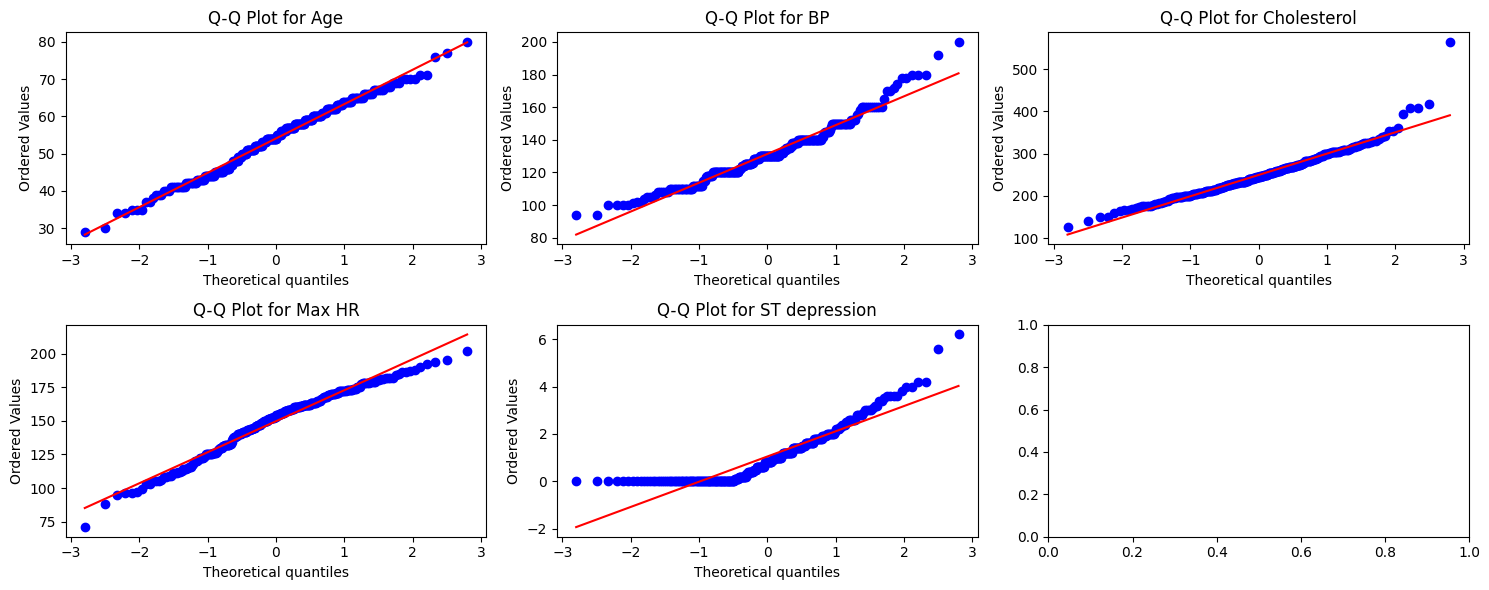

In [13]:
continuous_columns = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))
axes = axes.flatten()

# Plotting Q-Q plot for each feature in a separate subplot
for i, col in enumerate(continuous_columns):
    data = df[col]
    stats.probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {col}')

plt.tight_layout()
plt.show()

##### Data is Normally Distributed

#### 3. Separating Features for Scaling:
* Using RobustScaler for columns with outliers (BP, Cholesterol, Max HR, ST depression)
* Using StandardScaler for columns without outliers (Age)
* Categorical or binary columns are passed through without scaling. (Leaving the binary and ordinal variables without scaling, as scaling is not needed for categorical values that have an inherent ordering but are not continuous.)

In [14]:
cols_with_outliers = ['BP', 'Cholesterol', 'Max HR', 'ST depression']
cols_without_outliers = ['Age']
cols_no_scaling = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 
                   'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']

#### Pipeline for scaling and modeling
#### Hyperparameter Tuning with Cross-Validation

In [15]:
# Function to create a pipeline with scalers and a model
def build_pipeline(X: pd.DataFrame, y: pd.Series, model, param_grid: Dict[str, Any]) -> Any:
    # Defining the scalers
    robust_scaler = RobustScaler()
    standard_scaler = StandardScaler()

    # Creating the column transformer to apply scalers to specific columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('robust', robust_scaler, cols_with_outliers),        # RobustScaler to outlier columns
            ('standard', standard_scaler, cols_without_outliers)  # StandardScaler to other columns
        ],
        remainder = 'passthrough'    # Leaving categorical/binary columns as-is
    )

     # Creating the pipeline with the preprocessor and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Performing Grid Search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X, y)

    print(f"Model: {model}")
    print("\nBest parameters:", grid_search.best_params_)
    print("\nBest cross-validation score:", grid_search.best_score_)
    
    return grid_search

#### Model Evaluation

In [16]:
model_score = {}

In [17]:
# Function to store evaluation metrics in a dictionary
def evaluate_model_metrics(model_name: str, y_true: pd.Series, y_pred: pd.Series) -> Dict:
    
    # Calculating metrics
    accuracy = round(accuracy_score(y_true, y_pred) * 100, 2)
    f1 = round(f1_score(y_true, y_pred, zero_division=0) * 100, 2)
    recall = round(recall_score(y_true, y_pred, zero_division=0) * 100, 2)
    precision = round(precision_score(y_true, y_pred, zero_division=0) * 100, 2)

    # Printing results
    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy}%")
    print(f"F1 Score: {f1}%")
    print(f"Recall: {recall}%")
    print(f"Precision: {precision}%")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    return  {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1_score": f1,
    }

In [18]:
def plot_confusion_matrix(cm,title='Confusion Matrix', cmap=plt.cm.Reds, display_metrics=True):
    plt.figure(figsize=(7, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    #0 -> No Heart Disease | 1 -> Heart Disease
    classes = ['No Heart Disease', 'Heart Disease']
    plt.xticks(ticks=np.arange(len(classes)), labels=classes)
    plt.yticks(ticks=np.arange(len(classes)), labels=classes)

     # Add text annotations to each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}',
                     ha='center', va='center',
                     color='white' if cm[i, j] > cm.max() / 2. else 'black')
            
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

### Model Building

<div style="background-color: #e8f5e0; padding: 20px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 500px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 30px; margin-bottom: 10px; text-align: center;">
        Logistic Regression
    </h2>
</div>

##### Logistic Regression
*  Logistic Regression is used to predict categorical outcomes, typically a binary outcome of 0 or 1.
* Logistic Function (Sigmoid): The logistic regression model uses the logistic function (or sigmoid function) to map predicted values to probabilities between 0 and 1.
  
   <img src= "../images/log.png" width=700, height=600>

In [19]:
param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs', 'liblinear'],
    'model__max_iter': [400, 500, 600, 700],
    'model__tol': [1e-3, 1e-2],
    'model__fit_intercept': [True, False]
}

In [20]:
model = LogisticRegression(random_state=24, n_jobs=-1)

# Run the grid search to find the best model
grid_search = build_pipeline(X_train, y_train, model, param_grid_lr)
# Retrieving the best model
best_lr_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_lr = best_lr_model.predict(X_test)

Model: LogisticRegression(n_jobs=-1, random_state=24)

Best parameters: {'model__C': 1, 'model__fit_intercept': True, 'model__max_iter': 400, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'model__tol': 0.001}

Best cross-validation score: 0.8124893314367


In [21]:
metrics = evaluate_model_metrics("Logistic Regression", y_test, y_pred_lr)
model_score["Logistic Regression"] = list(metrics.values())

Logistic Regression Evaluation Metrics:
Accuracy: 85.19%
F1 Score: 84.62%
Recall: 91.67%
Precision: 78.57%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.79      0.92      0.85        24

    accuracy                           0.85        54
   macro avg       0.85      0.86      0.85        54
weighted avg       0.86      0.85      0.85        54



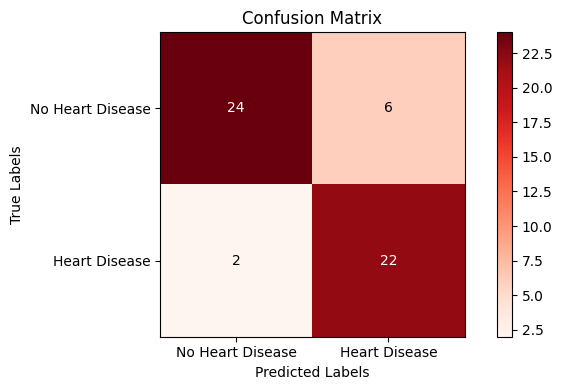

In [22]:
# Plot confusion matrix
lr_cm = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(lr_cm)

#### Interpretation:
* Class 0 (No Heart Disease) was identified with a precision of 92% and a recall of 80%, indicating a high rate of true negatives.
* Class 1 (Heart Disease) had good scores, with a recall of 92%, with a decent precision of 79%.
* In conclusion, this model provides a reasonably good prediction for heart disease cases.

#### Accessing Model Coefficients
* Accessing the coefficients (coef_) of the trained logistic regression model to understand the relationship between the features and the target variable. The coefficients tell us how much each feature contributes to the prediction.

In [23]:
# Extracting the logistic regression model from the pipeline
log_reg_model = best_lr_model.named_steps['model']

# Accessing the coefficients and intercept
coefficients = log_reg_model.coef_[0]
intercept = log_reg_model.intercept_

# Print or display coefficients as needed
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Displaying the coefficients with feature names 
feature_names = X_train.columns  # If X_train is a DataFrame with column names
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

coef_df.T

Coefficients: [ 0.33955368  0.38794804 -0.60595336  0.49513951 -0.0134354   1.40429779
  0.73572925  0.11191027  0.85338983  0.50005733  1.14792246  0.33523118]
Intercept: [-7.1404245]


,5,10,8,6,9,3,1,0,11,7,4,2
Feature,EKG results,Number of vessels fluro,ST depression,Max HR,Slope of ST,BP,Sex,Age,Thallium,Exercise angina,Cholesterol,Chest pain type
Coefficient,1.404298,1.147922,0.85339,0.735729,0.500057,0.49514,0.387948,0.339554,0.335231,0.11191,-0.013435,-0.605953


#### Understanding Feature Importance: (Calculating Odds Ratio)
* In logistic regression, the magnitude of the coefficients indicates the importance of the features, but the sign of the coefficient (positive or negative) tells us whether the feature is positively or negatively associated with the target.
* Positive coefficients indicate that the feature increases the likelihood of a positive prediction.
* Negative coefficients indicate that the feature decreases the likelihood of a positive prediction.

In [24]:
odds_ratios = np.exp(coefficients)
odds_ratio_df = pd.DataFrame({
    'Feature': feature_names,
    'Odds Ratio': odds_ratios
}).sort_values(by='Odds Ratio', ascending=False)

odds_ratio_df.T

,5,10,8,6,9,3,1,0,11,7,4,2
Feature,EKG results,Number of vessels fluro,ST depression,Max HR,Slope of ST,BP,Sex,Age,Thallium,Exercise angina,Cholesterol,Chest pain type
Odds Ratio,4.072666,3.151638,2.347591,2.087003,1.648816,1.640727,1.473953,1.404321,1.398264,1.118413,0.986654,0.545554


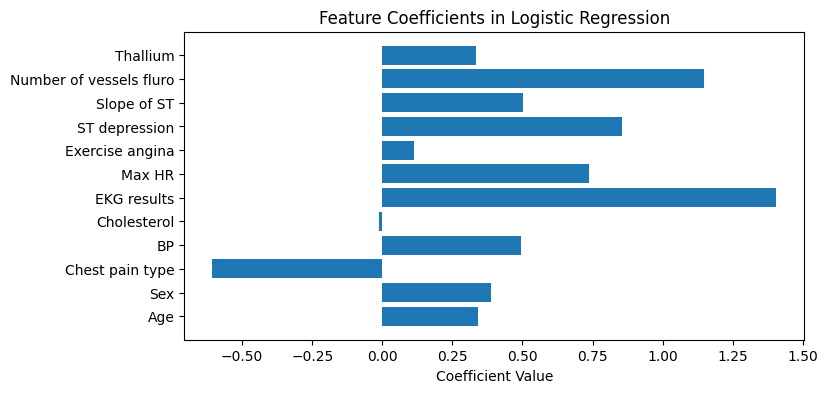

In [25]:
# Plotting the coefficients
plt.figure(figsize=(8, 4))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients in Logistic Regression')
plt.show()

#### Key Results:
1. Intercept:
* The intercept is -7.1404245. This represents the log-odds of the target variable when all the feature values are zero. In most cases, the intercept alone doesn't provide much insight unless we know the context of the feature values.

2. Coefficients and Odds Ratios:
* The coefficient values represent the change in the log-odds of the target variable for a one- 
  unit increase in the corresponding feature, assuming all other features remain constant.
* The odds ratio represents how the odds of the target variable (e.g., presence of heart disease) 
  change with a one-unit increase in the feature. An odds ratio greater than 1 means the feature 
  increases the odds of the target variable, while an odds ratio less than 1 means it decreases 
  the odds.

#### Interpretation: 
* EKG results, Number of vessels fluro, ST depression, Max HR, Slope of ST, and BP are all positive predictors of the target variable, meaning that higher values in these features increase the likelihood of the target (e.g., heart disease).
* Cholesterol has a very weak effect on the target variable (odds ratio near 1), and Chest pain type has a negative relationship with the target variable, meaning that higher values or different chest pain type reduce the odds of the target.
* Age, Sex, and Thallium also have a positive effect on the target variable, meaning older age, male sex, and higher thallium values increase the odds of the target occurring.

In [26]:
model_score

{'Logistic Regression': [85.19, 91.67, 78.57, 84.62]}

<div style="background-color: #e8f5e0; padding: 20px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 500px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 30px; margin-bottom: 10px; text-align: center;">
        Support Vector Machine
    </h2>
</div>

##### SVM
* A support vector machine (SVM) is a supervised machine learning algorithm that classifies data by finding an optimal line or hyperplane that maximizes the distance between each class in an N-dimensional space.
* In SVM, the model looks for the optimal hyperplane that best separates the classes. For a two-dimensional dataset, this boundary is a line; for three dimensions, it's a plane; and in higher dimensions, it's called a hyperplane. The hyperplane is chosen to maximize the distance between the classes, creating a margin.

  <img src="../images/svm.png" width=360, height=100 >

In [28]:
param_grid_svm = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__kernel': ['linear', 'poly', 'rbf'],
    'model__degree': [2, 3, 4],
    'model__max_iter': [400, 500, 600, 700],
    'model__tol': [1e-4, 1e-3, 1e-2],
    'model__gamma': [0.001, 0.01, 1, 10, 100]
}

model = SVC(random_state=24)

# Run the grid search to find the best model
grid_search = build_pipeline(X_train, y_train, model, param_grid_svm)
# Retrieving the best model
best_svm_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_svm = best_svm_model.predict(X_test)

Model: SVC(random_state=24)

Best parameters: {'model__C': 100, 'model__degree': 3, 'model__gamma': 0.01, 'model__kernel': 'poly', 'model__max_iter': 400, 'model__tol': 0.0001}

Best cross-validation score: 0.8316657834304892


In [29]:
metrics = evaluate_model_metrics("SVM", y_test, y_pred_svm)
model_score["SVM"] = list(metrics.values())

SVM Evaluation Metrics:
Accuracy: 81.48%
F1 Score: 80.0%
Recall: 83.33%
Precision: 76.92%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.77      0.83      0.80        24

    accuracy                           0.81        54
   macro avg       0.81      0.82      0.81        54
weighted avg       0.82      0.81      0.82        54



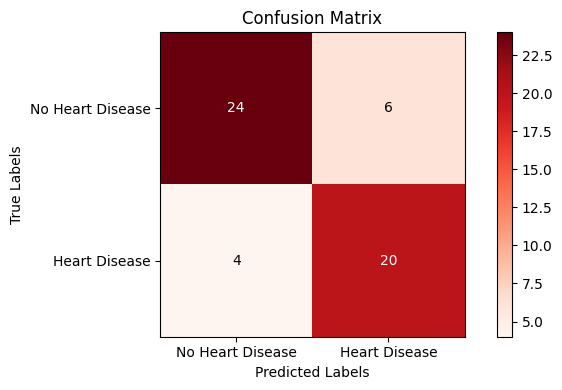

In [30]:
svm_cm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(svm_cm)

#### Interpretation:
* For class 0 (No Heart Disease), the model achieved an F1 score of 83%, while for class 1 (Heart Disease), it reached 80%, indicating that it is slightly more accurate at identifying non-disease cases but still performs effectively for both.
* Overall, this SVM model demonstrates solid reliability in predicting heart disease, making it a practical tool for early diagnosis and intervention.
* The model’s overall F1 score and recall are strong, indicating it’s particularly good at identifying true positives while maintaining balance with precision.

<div style="background-color: #e8f5e0; padding: 20px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 500px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 30px; margin-bottom: 10px; text-align: center;">
        KNN (K-Nearest Neighbors)
    </h2>
</div>

##### Distance Based Model
##### KNN (K-Nearest Neighbors)
* Distance-based models, such as k-Nearest Neighbors (k-NN), are a type of supervised learning algorithm that classifies data points based on their similarity to nearby points in feature space.
1. We will choose the value of K, which is the number of nearest neighbors that will be used to make the prediction.
2. Calculate the distance between that point and all the points in the training set.
3. Select the K nearest neighbors based on the distances calculated.
4. Assign the label of the majority class to the new data point.
5. Repeat steps 2 to 4 for all the data points in the test set.
6. Evaluate the accuracy of the algorithm.

In [31]:
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 15],  
    'model__weights': ['uniform', 'distance'],   
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],  
    'model__p': [1, 2],       # used if 'minkowski' metric is chosen (1 for manhattan, 2 for euclidean)
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

model = KNeighborsClassifier(n_jobs=-1)

# Run the grid search to find the best model
grid_search = build_pipeline(X_train, y_train, model, param_grid_knn)
# Retrieving the best model
best_knn_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_knn = best_knn_model.predict(X_test)

Model: KNeighborsClassifier(n_jobs=-1)

Best parameters: {'model__algorithm': 'auto', 'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__p': 1, 'model__weights': 'distance'}

Best cross-validation score: 0.7857528957528958


In [32]:
metrics = evaluate_model_metrics("KNN", y_test, y_pred_knn)
model_score["KNN"] = list(metrics.values())

KNN Evaluation Metrics:
Accuracy: 85.19%
F1 Score: 84.62%
Recall: 91.67%
Precision: 78.57%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.79      0.92      0.85        24

    accuracy                           0.85        54
   macro avg       0.85      0.86      0.85        54
weighted avg       0.86      0.85      0.85        54



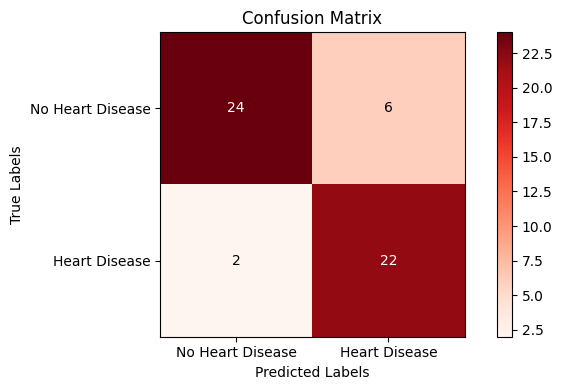

In [33]:
knn_cm = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(knn_cm)

In [34]:
# Extracting the KNN model from the pipeline
knn_model = best_knn_model.named_steps['model']

#### Interpretation:
* The model demonstrated balanced performance across metrics:
* Precision of 78.57% and Recall of 91.67% indicate that it effectively captures most heart disease cases while minimizing false positives.
* The model performs comparably well across both classes, with precision, recall, and F1 scores close for classes 0 and 1.

<div style="background-color: #e8f5e0; padding: 20px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 500px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 30px; margin-bottom: 10px; text-align: center;">
        Decision Tree
    </h2>
</div>

##### Tree- Based Models
##### Decision Tree
* A decision tree starts with a root node that signifies the whole population or sample, which then separates into two or more uniform groups via a method called splitting. When sub-nodes undergo further division, they are identified as decision nodes, while the ones that don't divide are called terminal nodes or leaves. A segment of a complete tree is referred to as a branch.

In [36]:
param_grid_dt = {
    'model__criterion': ['gini', 'entropy'],             # Splitting criterion
    'model__max_depth': [None, 10, 20, 30],          # Maximum depth of the tree
    'model__min_samples_split': [2, 5, 10],              # Minimum samples required to split an internal node
    'model__min_samples_leaf': [1, 2, 4],                # Minimum samples required to be at a leaf node
    'model__max_features': ['auto', 'sqrt', 'log2'],      # Number of features to consider for the best split
    'model__max_leaf_nodes': [None, 10, 20, 30],
    'model__min_impurity_decrease': [0.0, 0.01, 0.05]
}

model = DecisionTreeClassifier(random_state=42)

# Run the grid search to find the best model
grid_search = build_pipeline(X_train, y_train, model, param_grid_dt)
# Retrieving the best model
best_dt_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_dt = best_dt_model.predict(X_test)

Model: DecisionTreeClassifier(random_state=42)

Best parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': None, 'model__min_impurity_decrease': 0.01, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}

Best cross-validation score: 0.7592510688485921


In [37]:
metrics = evaluate_model_metrics("Decision Tree", y_test, y_pred_dt)
model_score["Decision Tree"] = list(metrics.values())

Decision Tree Evaluation Metrics:
Accuracy: 77.78%
F1 Score: 76.0%
Recall: 79.17%
Precision: 73.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        30
           1       0.73      0.79      0.76        24

    accuracy                           0.78        54
   macro avg       0.78      0.78      0.78        54
weighted avg       0.78      0.78      0.78        54



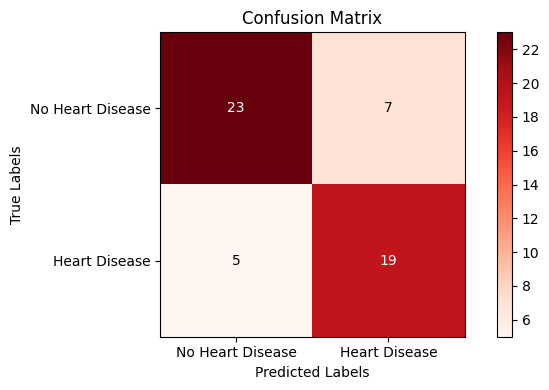

In [38]:
dt_cm = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(dt_cm)

#### Interpretation:
* F1 Score: At 76%, it balances precision and recall fairly well, indicating a trade-off where the model has a solid ability to classify both classes.
* Recall: Higher recall for the minority class (1) at 79.17% means the model is doing well in capturing most true positives, which is crucial if false negatives are costly.
* Precision: With a slightly lower precision for class 1 (73.08%), there may be some false positives, but it's balanced by recall.
* The f1 score got reduced here as compared to KNN and SVM. Will try Random Forest. 

#### Feature Importance

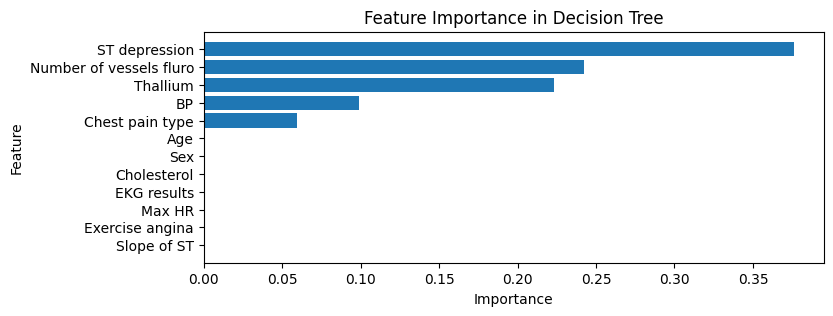

In [39]:
# Extracting the Decision Tree model from the pipeline
dt_model = best_dt_model.named_steps['model']

feature_importances = dt_model.feature_importances_
features = X_train.columns  
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 3))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.gca().invert_yaxis()
plt.show()

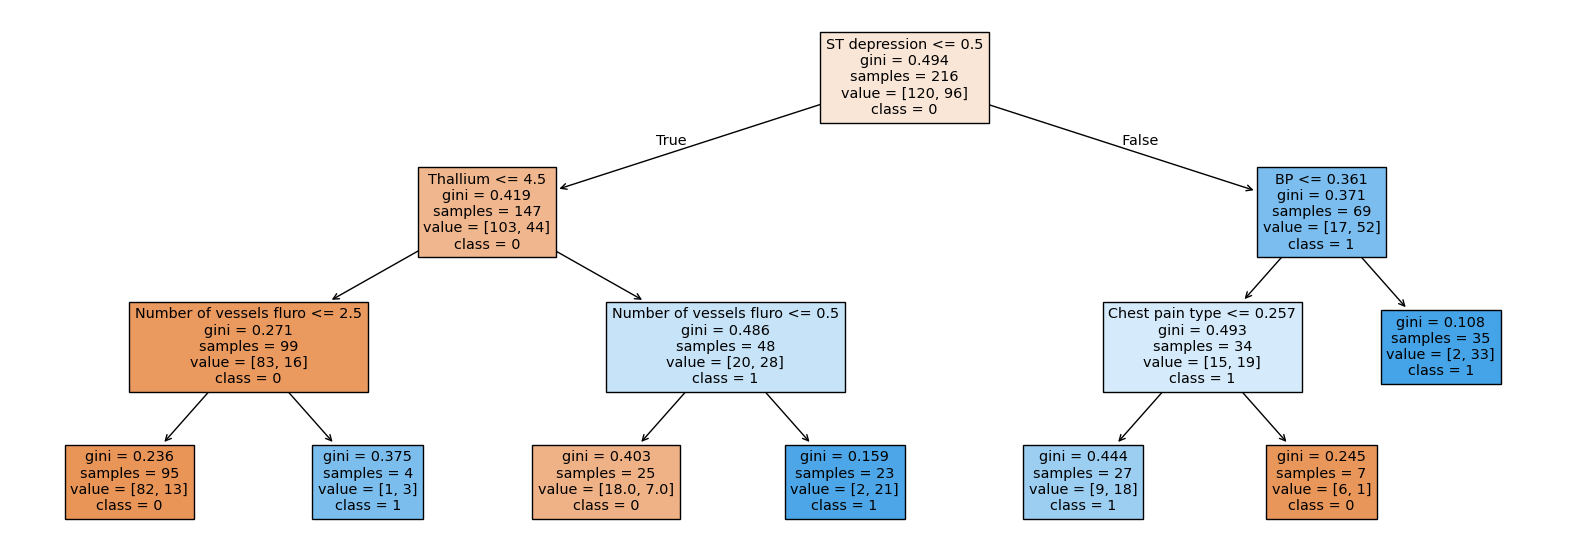

In [40]:
plt.figure(figsize=(20, 7))
plot_tree(dt_model, feature_names=X_train.columns, class_names=["0", "1"], filled=True)
plt.show()

<div style="background-color: #e8f5e0; padding: 20px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 500px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 30px; margin-bottom: 10px; text-align: center;">
        Random Forest
    </h2>
</div>

##### Random Forest
* A Random Forest consists of many decision trees, where each tree is trained on a random subset of the data. This is known as bootstrapping.
* When constructing each decision tree, Random Forest introduces randomness by selecting a subset of features at each split. Instead of considering all available features, only a random subset is used to determine the best split. This helps to decorrelate the trees, leading to a more robust overall model.
* For classification tasks, the final prediction is made by majority voting among the individual trees. Each tree votes for a class label, and the class with the most votes is selected as the final output.

In [41]:
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10], 
    'model__min_samples_leaf': [1, 2, 4],   
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__bootstrap': [True, False]      
}

model = RandomForestClassifier(n_jobs=-1, random_state=42)

# Run the grid search to find the best model
grid_search = build_pipeline(X_train, y_train, model, param_grid_rf)
# Retrieving the best model
best_rf_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_rf = best_rf_model.predict(X_test)

Model: RandomForestClassifier(n_jobs=-1, random_state=42)

Best parameters: {'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}

Best cross-validation score: 0.8151985994091258


In [42]:
metrics = evaluate_model_metrics("Random Forest", y_test, y_pred_rf)
model_score["Random Forest"] = list(metrics.values())

Random Forest Evaluation Metrics:
Accuracy: 81.48%
F1 Score: 80.0%
Recall: 83.33%
Precision: 76.92%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.77      0.83      0.80        24

    accuracy                           0.81        54
   macro avg       0.81      0.82      0.81        54
weighted avg       0.82      0.81      0.82        54



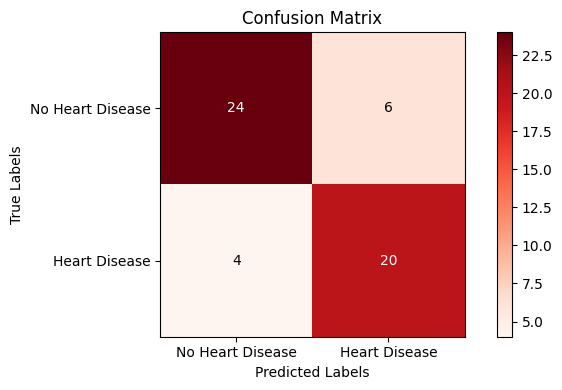

In [43]:
rf_cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(rf_cm)

#### Interpretation:
* For class 0 (No Heart Disease), the model has good precision (86%) and recall (80%).
* For class 1 (Heart Disease), while the recall is high (83%), precision is lower (77%), suggesting it could misclassify some non-disease cases as disease.

#### Feature Importance

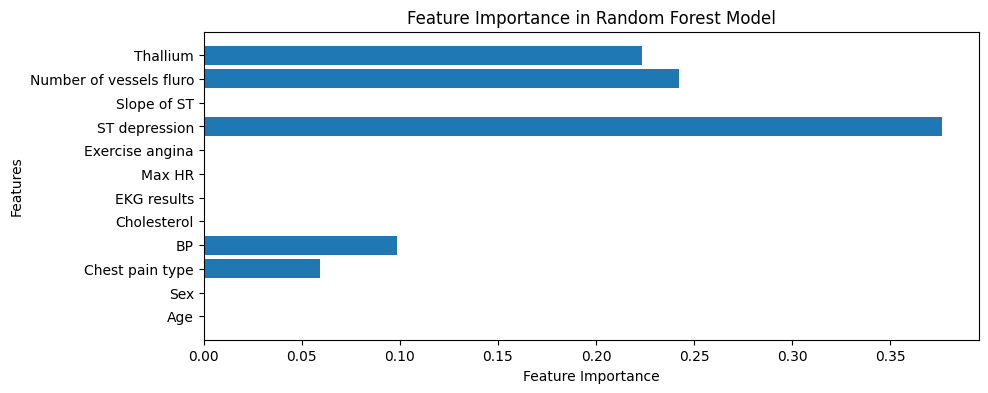

In [44]:
# Extracting the Random Forest model from the pipeline
rf_model = best_rf_model.named_steps['model']

# Extracting feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 4))
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.show()

#### Interpretation:
* The features like ST Depression, Number of vessels fluro,Thallium have higher importance scores, meaning they contribute more significantly to the model's predictions for heart disease.

<div style="background-color: #e8f5e0; padding: 15px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 500px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 30px; margin-bottom: 10px; text-align: center;">
        Boosting Models
    </h2>
</div>

<div style="background-color: #e8f5e0; padding: 20px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 500px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 30px; margin-bottom: 10px; text-align: center;">
        XGBoost
    </h2>
</div>

##### XGBoost
* XGBoost is an implementation of gradient boosting that creates an ensemble of weak learners (typically decision trees) in a sequential manner. Each tree attempts to correct the errors made by the previous trees, leading to improved accuracy.
* XGBoost includes L1 (Lasso) and L2 (Ridge) regularization, which helps reduce overfitting and enhances the model's generalization capability.
* The algorithm employs a technique called "max depth" for tree pruning, which improves the efficiency of the model by removing unnecessary nodes in the decision trees.

In [45]:
param_grid_xgb = {
    'model__n_estimators': [100, 200, 300],        # Number of boosting rounds
    'model__max_depth': [4, 6, 8],                 # Maximum depth of each tree
    'model__learning_rate': [0.01, 0.1, 0.2],       # Step size shrinkage
    'model__subsample': [0.8, 1],                  # Fraction of samples used per tree
    'model__colsample_bytree': [0.8, 1],          # Fraction of features used per tree
    'model__gamma': [0, 0.1, 0.3, 0.5],             # Minimum loss reduction to make a split
    'model__reg_alpha': [0, 0.1, 0.5],              # L1 regularization term on weights
    'model__reg_lambda': [1, 1.5, 2],               # L2 regularization term on weights
}

model = XGBClassifier(random_state=42)

# Run the grid search to find the best model
grid_search = build_pipeline(X_train, y_train, model, param_grid_xgb)
# Retrieving the best model
best_xgb_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_xgb = best_xgb_model.predict(X_test)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Best parameters: {'model__colsample_bytree': 1, 'model__gamma': 0.1, 'model__learning_rate': 0.2, 'model__max_depth': 8, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 1.5, 'model__subsample': 1}

Best cross-val

In [46]:
metrics = evaluate_model_metrics("XG Boost", y_test, y_pred_xgb)
model_score["XG Boost"] = list(metrics.values())

XG Boost Evaluation Metrics:
Accuracy: 83.33%
F1 Score: 81.63%
Recall: 83.33%
Precision: 80.0%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.80      0.83      0.82        24

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



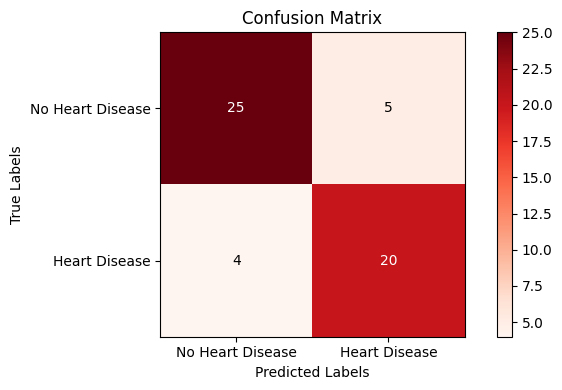

In [47]:
xgb_cm = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(xgb_cm)

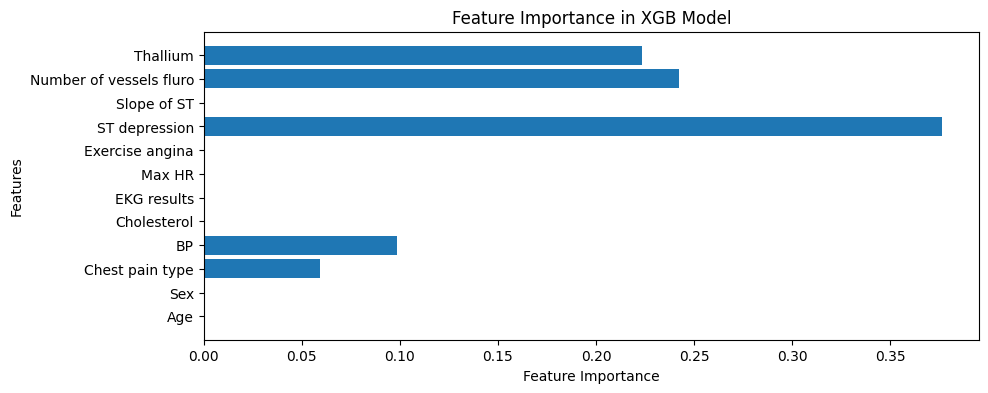

In [48]:
# Extracting the XGBoost model from the pipeline
xgb_model = best_xgb_model.named_steps['model']

# Extracting feature importances
importances = xgb_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 4))
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in XGB Model')
plt.show()

#### Interpretation:
* Class 0 (Negative): The model has a precision of 86% and recall of 83%, indicating it performs well in identifying true negatives.
* Class 1 (Positive): With a precision of 80% and recall of 83%, the model is reliable in predicting positive cases, although there is a slight trade-off in precision.
* The top 3 features have high importance and the rest have equal and low importance.

<div style="background-color: #e8f5e0; padding: 20px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 500px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 30px; margin-bottom: 10px; text-align: center;">
        Light GBM
    </h2>
</div>

##### Light GBM
* LightGBM (Light Gradient Boosting Machine) is an open-source, distributed, high-performance implementation of gradient boosting framework developed by Microsoft.
* LightGBM is based on the gradient boosting technique, where decision trees are built sequentially, and each new tree aims to correct errors made by the previously trained trees.
* It is designed to be faster and more memory-efficient than traditional gradient boosting algorithms like XGBoost. This is achieved through several optimizations, such as histogram-based learning and leaf-wise tree growth.
* LightGBM uses a histogram-based approach to speed up the training process. Instead of evaluating each individual data point, it bins the continuous values into discrete intervals (bins) and works with these histograms, reducing the computation time significantly.

In [50]:
param_grid_lgbm = {
    'model__n_estimators': [50, 100, 200],             # Number of boosting rounds
    'model__learning_rate': [0.01, 0.05, 0.1],         # Step size shrinkage
    'model__num_leaves': [20, 31, 40],                 # Maximum number of leaves in one tree
    'model__max_depth': [-1, 10, 20],                 # Maximum tree depth (-1 means no limit)
    'model__min_child_samples': [5, 10, 20],           # Minimum number of samples per leaf
}

model = LGBMClassifier(random_state=42, verbose=-1)

# Run the grid search to find the best model
grid_search = build_pipeline(X_train, y_train, model, param_grid_lgbm)
# Retrieving the best model
best_lgbm_model = grid_search.best_estimator_
# Make predictions with the best model
y_pred_lgbm = best_lgbm_model.predict(X_test)

Model: LGBMClassifier(random_state=42, verbose=-1)

Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 100, 'model__num_leaves': 20}

Best cross-validation score: 0.8071834992887623


In [51]:
metrics = evaluate_model_metrics("Light GBM", y_test, y_pred_lgbm)
model_score["Light GBM"] = list(metrics.values())

Light GBM Evaluation Metrics:
Accuracy: 83.33%
F1 Score: 81.63%
Recall: 83.33%
Precision: 80.0%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.80      0.83      0.82        24

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



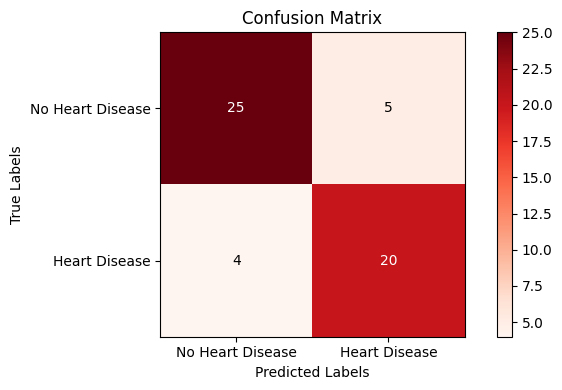

In [52]:
lgbm_cm = confusion_matrix(y_test, y_pred_lgbm)
plot_confusion_matrix(lgbm_cm)

#### Interpretation:
* Class 0 (Negative): The model achieved a precision of 86% and recall of 83%, showing strong performance in identifying true negatives.
* Class 1 (Positive): The model exhibited a precision of 80% and recall of 83%, indicating it is effective in identifying positive cases while maintaining a reasonable level of precision.

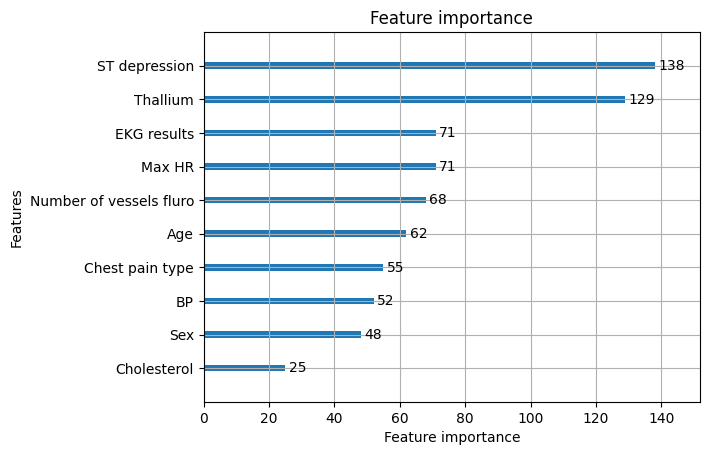

In [53]:
# Extracting the XGBoost model from the pipeline
lgbm_model = best_lgbm_model.named_steps['model']

importances = lgbm_model.feature_importances_
# Sort feature importances and get the indices of the top 10
indices = importances.argsort()[::-1][:10]
lgb.plot_importance(lgbm_model,  importance_type='split', max_num_features=10)
plt.yticks(ticks=range(10), labels=X_train.columns[indices])
plt.show()

In [54]:
model_score

{'Logistic Regression': [85.19, 91.67, 78.57, 84.62],
 'SVM': [81.48, 83.33, 76.92, 80.0],
 'KNN': [85.19, 91.67, 78.57, 84.62],
 'Decision Tree': [77.78, 79.17, 73.08, 76.0],
 'Random Forest': [81.48, 83.33, 76.92, 80.0],
 'XG Boost': [83.33, 83.33, 80.0, 81.63],
 'Light GBM': [83.33, 83.33, 80.0, 81.63]}

In [55]:
score_df = pd.DataFrame(model_score).transpose()
score_df.rename(columns = {0 :'Accuracy', 1:'Recall' , 2: 'Precision', 3:'f1_score'}, inplace = True)
score_df.sort_values(by = 'f1_score', ascending = False, inplace = True)

In [56]:
score_df

,Accuracy,Recall,Precision,f1_score
Logistic Regression,85.19,91.67,78.57,84.62
KNN,85.19,91.67,78.57,84.62
XG Boost,83.33,83.33,80.00,81.63
Light GBM,83.33,83.33,80.00,81.63
SVM,81.48,83.33,76.92,80.00
Random Forest,81.48,83.33,76.92,80.00
Decision Tree,77.78,79.17,73.08,76.00


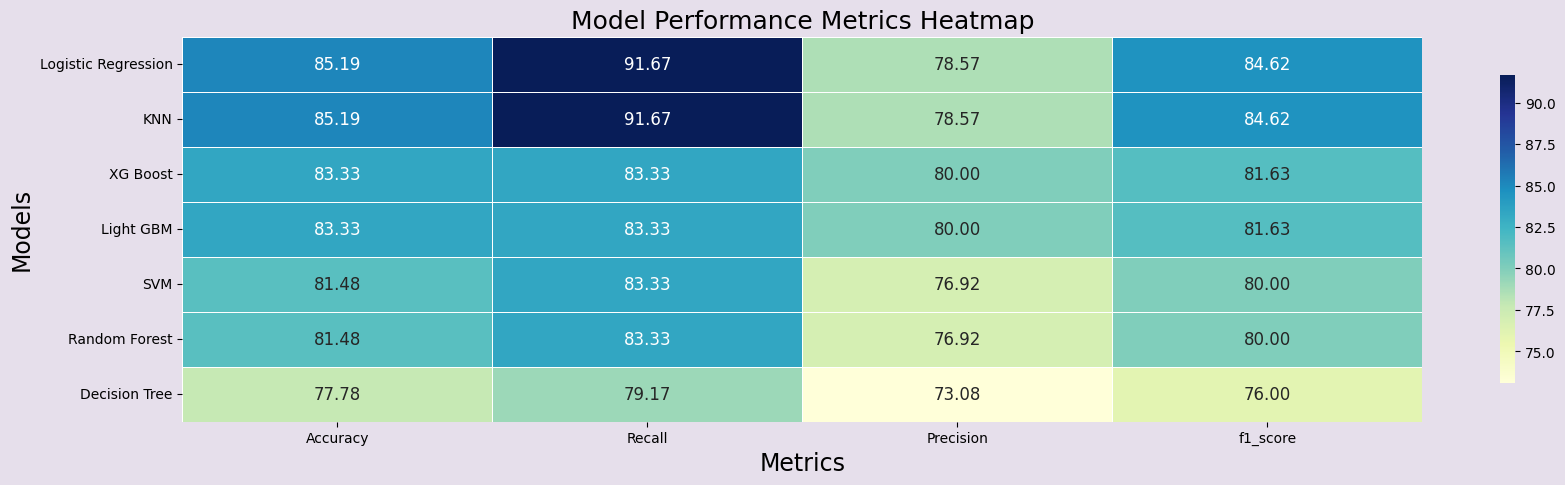

In [57]:
fig = plt.figure(figsize=(20,5), facecolor = '#e6dfeb')
axes = plt.subplot2grid((1,1),(0,0))

sns.heatmap(
    data = score_df, cmap='YlGnBu', annot = True,fmt='.2f', annot_kws={"size": 12},  
    cbar_kws={"shrink": 0.8},  linewidths=0.5,  linecolor='white' ,
      )

plt.xlabel('Metrics', fontsize=17)
plt.ylabel('Models', fontsize=17)
plt.title('Model Performance Metrics Heatmap', fontsize=18)

plt.show()

### Conclusion:
#### Logistic Regression and KNN:
    * These two models stand out as the best performers based on all metrics (Accuracy, Recall, 
      Precision, and F1 Score).
#### XGBoost and LightGBM:
    * These models have similar performance, slightly lower than Logistic Regression and KNN but 
      still competitive, with good precision and recall.

#### SVM and Random Forest:
    * These models have slightly lower performance in terms of precision and F1 score. They 
      perform well on recall but don't outperform Logistic Regression or KNN.

#### Decision Tree:
    * This model performs the worst across all metrics and should generally be avoided in favor of 
     better-performing models.

#### Final Model Choice:
    * Top Choices: Logistic Regression and KNN are the best candidates because they have the 
      highest accuracy, recall, and F1 score. They also have relatively high precision.
    * Secondary Choices: XGBoost and LightGBM are also good models, especially if one is looking 
    for tree-based models and can handle more complexity. These models are slightly less accurate 
      but offer a good balance of recall, precision, and F1 score.

### Saving Models:

In [27]:
with open('../Saved_Models/log_reg_model.pkl', 'wb') as file:
    pickle.dump(log_reg_model, file)

# Saving the best model pipeline (including preprocessing and model) for later use
with open('../Saved_Models/best_lr_model_pipeline.pkl', 'wb') as model_file:
    pickle.dump(log_reg_model, model_file)

In [35]:
with open('../Saved_Models/knn_model.pkl', 'wb') as file:
    pickle.dump(knn_model, file)

# Saving the best model pipeline (including preprocessing and model) for later use
with open('../Saved_Models/best_knn_model_pipeline.pkl', 'wb') as model_file:
    pickle.dump(knn_model, model_file)

In [49]:
with open('../Saved_Models/xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

# Saving the best model pipeline (including preprocessing and model) for later use
with open('../Saved_Models/best_xgb_model_pipeline.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)

In [58]:
with open('../Saved_Models/lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)

# Saving the best model pipeline (including preprocessing and model) for later use
with open('../Saved_Models/best_lgbm_model_pipeline.pkl', 'wb') as model_file:
    pickle.dump(lgbm_model, model_file)

<div style="background-color: #e8f5e9; padding: 20px; border-radius: 8px; border: 1px solid #c8e6c9; max-width: 700px; margin: auto;">
    <h2 style="font-family: Arial, sans-serif; color: #2e7d32; font-size: 28px; margin-bottom: 10px; text-align: center;">
      Conclusion </h2>
    <p style="font-family: Arial, sans-serif; color: #555; font-size: 16px; line-height: 1.5; text-align: justify;">
        To predict heart disease effectively, various machine learning models were constructed, fine-tuned, and evaluated based on performance metrics. Key steps in the model building process included data preprocessing, feature selection, and hyperparameter tuning. The primary models explored are listed below:
    </p>
    <ul style="font-family: Arial, sans-serif; color: #555; font-size: 16px; line-height: 1.5; padding-left: 20px;">
        <li><strong>Logistic Regression:</strong> A baseline model used to establish initial predictive accuracy. Hyperparameters were tuned for optimal performance.</li>
        <li><strong>Support Vector Machine (SVM):</strong> Explored with various kernels to assess its performance on our dataset.</li>
        <li><strong>Random Forest:</strong> An ensemble method to improve prediction by combining multiple decision trees. Feature importance was also analyzed.</li>
        <li><strong>XGBoost:</strong> A boosting algorithm that provides higher accuracy by sequentially improving weak learners. Tuning included adjusting learning rates, max depth, and n_estimators.</li>
    </ul>
    <p style="font-family: Arial, sans-serif; color: #555; font-size: 16px; line-height: 1.5; text-align: justify;">
        Each model was evaluated based on metrics such as accuracy, precision, recall, and F1-score to determine the best performing model for heart disease prediction.
    </p>
</div>
